In [9]:
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# visualizatio libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools
        

In [10]:
# importing the data directory
train_dir = '../input/nike-adidas-and-converse-imaged/train'
test_dir = '../input/nike-adidas-and-converse-imaged/test'

# specifying few basic elements in the begaining itself
BATCH_SIZE = 32
NUM_CLASSES = 15
IMG_WIDTH, IMG_HEIGHT = 224, 224


# SNEEK PEEK INTO THE DATA

In [11]:
# creating a function that displays random
def view_random_image(target_dir, target_class):
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = mpimg.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  
  return img

Image shape: (240, 240, 3)


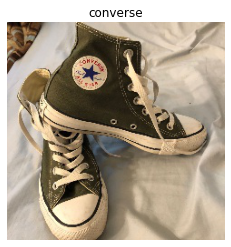

In [12]:
img = view_random_image(target_dir = "/kaggle/input/nike-adidas-and-converse-imaged/train/",
                        target_class = "converse") # or we can write nike instead of converse to see converse examples

Image shape: (240, 240, 3)
Image shape: (240, 240, 3)
Image shape: (240, 240, 3)


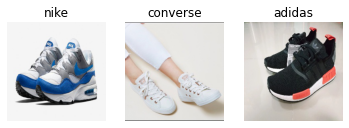

In [13]:
img.shape #(width, height, colour channels)
plt.figure()
plt.subplot(1,3,1)
steak_image = view_random_image("/kaggle/input/nike-adidas-and-converse-imaged/train/", "nike")
plt.subplot(1,3,2)
pizza_image = view_random_image("/kaggle/input/nike-adidas-and-converse-imaged/train/", "converse")
plt.subplot(1,3,3)
pizza_image = view_random_image("/kaggle/input/nike-adidas-and-converse-imaged/train/", "adidas")

# creatinf a data generator function

In [14]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                                  horizontal_flip= True,
                                  width_shift_range= 0.05,
                                  height_shift_range= 0.1,
                                  validation_split=0.1,
                                  rotation_range= 10,
                                  preprocessing_function=  tf.keras.applications.resnet.preprocess_input
                                  )


train_generator = train_datagen.flow_from_directory(directory= train_dir,
                                                    target_size= (IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle = True,
                                                    color_mode = 'rgb',
                                                    subset = 'training',
                                                    class_mode = 'categorical',
                                                    seed = 2
                                                   )

valid_generator = ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=train_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    )

    
test_datagen = ImageDataGenerator(rescale= 1./255,
                                 preprocessing_function=  tf.keras.applications.resnet.preprocess_input)


test_generator = test_datagen.flow_from_directory(directory= test_dir,
                                                 target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size = BATCH_SIZE,
                                                 shuffle= False,
                                                 color_mode= 'rgb',
                                                 class_mode = 'categorical',
                                                 seed = 2)


Found 642 images belonging to 3 classes.
Found 69 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


# TAKING A PRETRAINED MODEL

In [15]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

2022-09-23 05:52:22.466551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 05:52:22.603027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 05:52:22.603803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 05:52:22.605544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# CREATING A BASIC YET POWERFUL NEURL NETWORK

In [16]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax') # 3 Output Neurons for 3 Classes

])

In [17]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

In [18]:
# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
# Viewing the summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 23,904,035
Trainable params: 2,101,251
Non-trainable params: 21,802,784
_________________________________________________________________


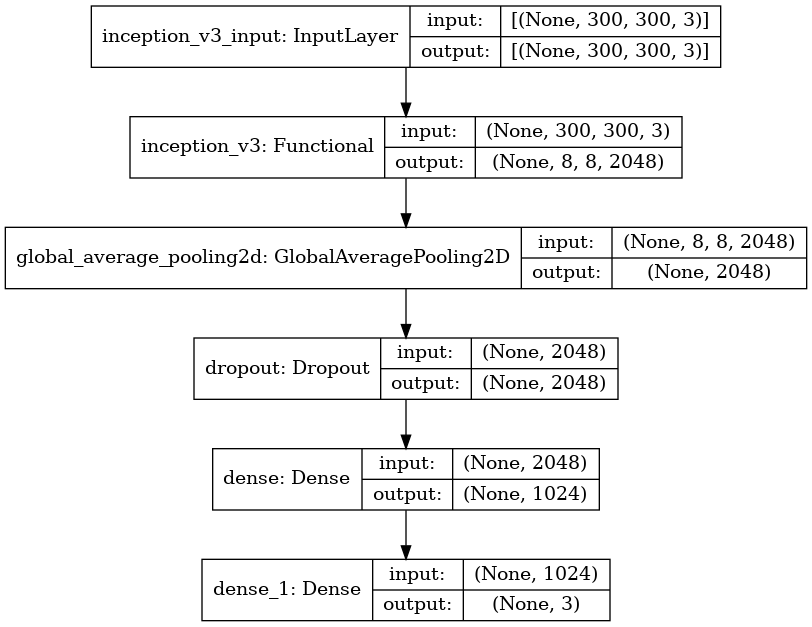

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

batch_size = 32
epochs = 10

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator,
                              epochs=10,
#                               steps_per_epoch=train_generator.n // batch_size,
                              validation_data=valid_generator,
#                               validation_steps=valid_generator.n // batch_size,
                              callbacks=callbacks_list)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-09-23 05:52:31.335477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-09-23 05:52:36.674152: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 5/21 [======>.......................] - ETA: 5s - loss: 1.2075 - accuracy: 0.3615

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

In [ ]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("./model_10-0.80.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'adidas', 1: 'converse', 2: 'nike'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()